---
jupytext:
  cell_metadata_filter: all, -hidden, -heading_collapsed, -run_control, -trusted
  notebook_metadata_filter: all, -jupytext.text_representation.jupytext_version, -jupytext.text_representation.format_version, -language_info.version, -language_info.codemirror_mode.version, -language_info.codemirror_mode, -language_info.file_extension, -language_info.mimetype, -toc
  text_representation:
    extension: .md
    format_name: myst
kernelspec:
  display_name: Python 3 (ipykernel)
  language: python
  name: python3
language_info:
  name: python
  nbconvert_exporter: python
  pygments_lexer: ipython3
nbhosting:
  title: 'Correction du TP régression ridge'
  version: '1.0'
---

<div class="licence">
<span><img src="media/logo_IPParis.png" /></span>
<span>Lisa BEDIN<br />Pierre André CORNILLON<br />Eric MATZNER-LOBER</span>
<span>Licence CC BY-NC-ND</span>
</div>

# Modules

Importer les modules pandas (comme `pd`) numpy (commme `np`) le sous module `pyplot` de `matplotlib` comme `plt` les fonctions `StandardScaler` de `sklearn.preprocessing`, `Ridge` de `sklearn.linear_model`, `RidgeCV` de `sklearn.linear_model`, `Pipeline` de `sklearn.pipeline`, `cross_val_predict` de `sklearn.model_selection`, `KFold` de `sklearn.model_selection` `make_scorer` de `sklearn.metrics`

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import KFold
from sklearn.metrics import make_scorer

# Régression ridge sur les données d'ozone


## Importation des données

Importer les données d'ozone `ozonecomplet.csv` et éliminer les deux dernières variables (qualitatives) et faites un résumé numérique par variable [méthode `astype` sur la colonne du DataFrame et méthode `describe` sur l'instance DataFrame\]

In [2]:
ozone = pd.read_csv("data/ozonecomplet.csv", header=0, sep=";")
ozone = ozone.drop(['nomligne', 'Ne', 'Dv'], axis=1)
ozone.describe()

,O3,T9,T12,T15,Ne9,Ne12,Ne15,Vx9,Vx12,Vx15,O3v
count,112.000000,112.000000,112.000000,112.000000,112.000000,112.000000,112.000000,112.000000,112.000000,112.000000,112.000000
mean,90.303571,18.360714,21.526786,22.627679,4.928571,5.017857,4.830357,-1.214346,-1.611004,-1.690683,90.571429
std,28.187225,3.122726,4.042321,4.530859,2.594916,2.281860,2.332259,2.632742,2.795673,2.810198,28.276853
min,42.000000,11.300000,14.000000,14.900000,0.000000,0.000000,0.000000,-7.878500,-7.878500,-9.000000,42.000000
25%,70.750000,16.200000,18.600000,19.275000,3.000000,4.000000,3.000000,-3.276450,-3.564700,-3.939200,71.000000
50%,81.500000,17.800000,20.550000,22.050000,6.000000,5.000000,5.000000,-0.866000,-1.879400,-1.549650,82.500000
75%,106.000000,19.925000,23.550000,25.400000,7.000000,7.000000,7.000000,0.694600,0.000000,0.000000,106.000000
max,166.000000,27.000000,33.500000,35.500000,8.000000,8.000000,8.000000,5.196200,6.577800,5.000000,166.000000


## Création des tableaux `numpy`

avec l'aide des méthodes d'instance `iloc` ou `loc` créer les tableaux `numpy` `y` et `X` (on se servira de l'attribut `values` qui donne le tableau `numpy` sous-jascent)

In [3]:
y = ozone.O3.values
X = ozone.iloc[:,1:].values

## Centrage et réduction

Centrer et réduire les variable avec `StandardScaler` selon le schéma suivant

1.  créer une instance avec la fonction `StandardScaler`. On notera `scalerX` l'instance créée.
2.  l'ajuster via la méthode d'instance `fit` (calcul des moyennes et écart-types) et avec le tableau `numpy` des $X$
3.  Transformer le tableau $X$ en tableau centré réduit via la méthode d'instance `transform` et avec le tableau `numpy` des $X$.

In [4]:
scalerX = StandardScaler().fit(X)
Xcr= scalerX.transform(X)

## Calcul de la régression Ridge pour $\lambda=0.00485$

1.  Estimation/ajustement: en utilisant les données centrées réduites pour $X$ et le vecteur `y` estimer le modèle de régression Ridge:
    -   Instancier un modèle `Ridge` avec la fonction éponyme

In [7]:
ridge = Ridge(alpha=0.00485)
ridge.fit(Xcr, y)

Ridge(alpha=0.00485)

2.  Afficher $\hat\beta(\lambda)$

In [8]:
print(ridge.coef_)

[-0.05647245  8.93275737  2.52242717 -5.65394122 -0.95834909  0.42724318
  2.4850383   0.0863599   1.17132698  9.90737987]


3.  Prévoir une valeur en $x^*=(17, 18.4, 5, 5, 7, -4.3301, -4, -3, 87)'$ (on pourra constater qu'il s'agit de la seconde ligne du tableau initial).

In [9]:
print(ridge.predict(Xcr[1,:].reshape(1, 10)))

[76.0489625]


## Pipeline

On voit bien que si l'on nous donne des valeurs nouvelles il faut enlever la moyenne et diviser par l'écart-type ce qui n'est pas très pratique.

-   Vérifier que `scalerX.transform(X[1,:].reshape(1, 10))` donne bien `Xcr[1,:]`. Cependant l'enchainement «transformation des X» puis «modélisation» peut être automatisé grâce au [Pipeline](https://scikit-learn.org/stable/tutorial/statistical_inference/putting_together.html)

In [10]:
np.all(np.abs( scalerX.transform(X[1,:].reshape(1, 10))[0,:] - Xcr[1,:])<1e-10)

True

-   Créer une instance de pipeline:
    1.  Créer une instance de `StandardScaler`

In [ ]:
cr = StandardScaler()

2.  Créer une instance de Régression Ridge

In [ ]:
ridge = Ridge(alpha=0.00485)

3.  Créer une instance de `Pipeline` avec l'argument `steps` qui sera une liste de tuple dont le premier élément est le nom de l'étape (par exemple `"cr"` ou `"ridge"`) et dont la seconde valeur sera l'instance de l'étape à faire (instances créées aux étapes précédentes.)

In [ ]:
pipe = Pipeline(steps=[("cr", cr) , ("ridge",  ridge)])

-   ajuster cette instance de pipeline avec la méthode d'instance `fit` avec les données `X` et `y`.

In [ ]:
pipe.fit(X,y)

-   Retrouver les paramètres $\hat\beta(\lambda)$ en affectant la coordonnée `"ridge"` (nom de l'étape choisi ici) de l'attribut named<sub>steps</sub> dans un objet. Les attributs et méthodes de cet objets seront ensuite les mêmes que ceux la régression `Ridge` après ajustement.

In [ ]:
er=pipe.named_steps["ridge"]
print(er.coef_)

-   Retrouver l'ajustement pour $x^*$

In [ ]:
print(pipe.predict(X[1,:].reshape(1,10)))

## Evolution des coefficients selon $\lambda$


### Calcul d'une grille de $\lambda$

La grille classique pour ridge est constituée sur la même idée que celle pour le lasso:

1.  Calcul de la valeur maximale $\lambda_0 = \arg\max_{i} |[X'y]_i|/n$ Pour le lasso au delà de cette contrainte tous les coefficients sont nuls.
2.  On prend une grille en puissance de 10, avec les exposants qui varient entre 0 et -4 (en général on prend 100 valeurs régulièrement espacées)
3.  Cette grille est multipliée par $\lambda_0$
4.  Pour la régression ridge la grille précédente (qui est celle pour le lasso) est multipliée par $100$ ou $1000$.

On a donc la grille $\{\lambda_0 10^{k+2}\}_{k=0}^{-4}$.

Créer cette grille avec `np.linspace`, méthode d'instance `transpose`, `dot` et `max` (sans oublier l'attribut `shape` pour $n$).

In [12]:
llc = np.linspace(0, -4, 100)
l0 = np.abs(Xcr.transpose().dot(y)).max()/X.shape[0]
alphas_ridge = l0*100*10**(llc)

### Tracer l'évolution des $\hat\beta(\lambda)$

Tracer en fonction du logarithme des valeurs de $\lambda$ de la grille les coefficients $\hat\beta(\lambda)$

D'abord la liste des coefficients:

In [13]:
lcoef = []
for ll in alphas_ridge:
    pipe = Pipeline(steps=[("cr", StandardScaler()) , ("ridge",  Ridge(alpha=ll))]).fit(X,y)
    er = pipe.named_steps["ridge"]
    lcoef.append(er.coef_)

ou sans le pipeline

In [14]:
lcoef = []
for ll in alphas_ridge:
    rr = Ridge(alpha=ll).fit(Xcr,y)
    lcoef.append(rr.coef_)

Puis le tracé

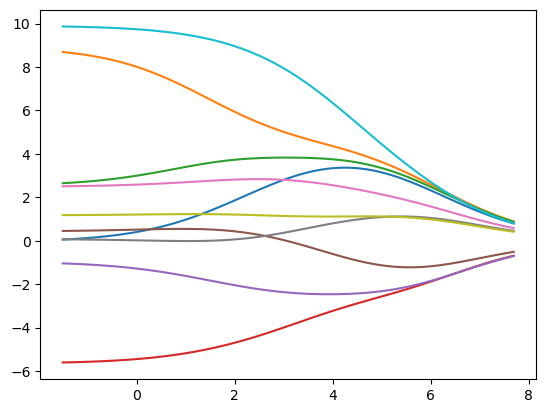

In [15]:
plt.plot(np.log(alphas_ridge), lcoef)
plt.show()

Nous voyons clairement que les valeurs sont retrécies vers 0 quand la valeur de $\lambda$ augmente.


## $\hat \lambda$ optimal (par validation croisée 10 blocs/fold)


### Séparation en 10 blocs

Nous allons séparer le jeu de données en 10 blocs grâce à la fonction [KFold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html#sklearn.model_selection.KFold): créer une instance de `KFold` nommée `kf`.

In [16]:
kf = KFold(n_splits = 10, shuffle=True, random_state=0)

### Sélection du $\hat \lambda$ optimal

1.  Créer un DataFrame `res` avec 100 colonnes de 0
2.  Faire une boucle sur tous les blocs ; utiliser la méthode d'instance `split` sur `kf` avec les données `X`
3.  Pour chaque «tour» de bloc faire a. estimer sur les 9 blocs en apprentissage les modèles ridge pour chaque $\lambda$ de la grille. b. prévoir les données du bloc en validation c. ranger dans les lignes correspondantes de `res` pour les 100 colonnes correspondantes aux 100 modèles ridge.

In [17]:
kf = KFold(n_splits=10, shuffle=True, random_state=0)
res = pd.DataFrame(np.zeros((X.shape[0], len(alphas_ridge))))
for app_index, val_index in kf.split(X):
    Xapp = Xcr[app_index,:]
    yapp = y[app_index]
    Xval = Xcr[val_index,:]
    yval = y[val_index]
    for j, ll in enumerate(alphas_ridge):
        rr = Ridge(alpha=ll).fit(Xapp, yapp)
        res.iloc[val_index,j] = rr.predict(Xval)

## Sélection du $\hat \lambda$ optimal

En prenant l'erreur quadratique $\|Y - \hat Y(\lambda)\|^2$ donner le meilleur modèle (et donc le $\hat \lambda$ optimal ) \[méthode d'instance `apply` sur `res` et `argmin` \]

In [18]:
sse = res.apply(lambda x: ((x-y)**2).sum(), axis=0)
print(alphas_ridge[sse.argmin()])

23.055161479861606


## Représentation graphique

Représenter en abscisse les logarithmes des valeurs de $\lambda$ sur la grille et en ordonnée l'erreur quadratique calculée en question précédente.

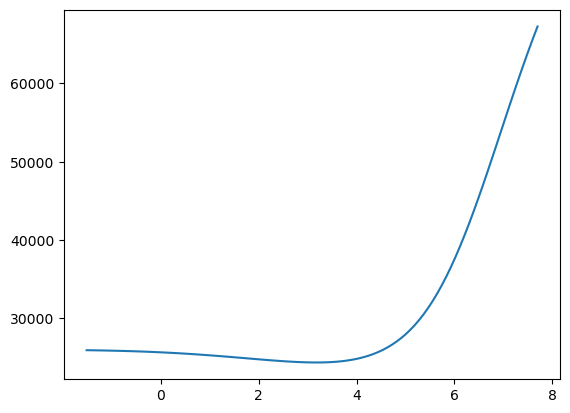

In [19]:
plt.plot(np.log(alphas_ridge), sse, "-")

## Modéliser rapidement

Les questions précédentes peuvent être enchainées plus rapidement grâce à [=cross<sub>val</sub><sub>predict</sub>=\]

1.  Les questions précédentes peuvent être enchainées plus rapidement grâce à $$ =cross_val_predict= $$ (la grille devra être calculée à la main) Calcul de la grille (il n'existe pas encore de calcul de grille)

In [ ]:
l0 = np.abs(Xcr.transpose().dot(y)).max()/X.shape[0]
alphas_ridge = l0*100*10**(llc)

In [ ]:
Ici on va utiliser la fonction RidgeCV avec toujours `kf`




In [ ]:
kf = KFold(n_splits=10, shuffle=True, random_state=0)
modele_ridge = RidgeCV(alphas=alphas_ridge, cv=kf, scoring = 'neg_mean_squared_error').fit(Xcr, y)

In [ ]:
print(modele_ridge.alpha_)

In [ ]:
27.770023623731202

ainsi que $\hat\beta(\hat\lambda)$

In [ ]:
print(modele_ridge.coef_)

In [ ]:
[ 3.04681722  4.7852898   3.82669397 -3.74215398 -2.42237328 -0.16252902
  2.7504887   0.50796561  1.12687075  7.4831738 ]

1.  Si nous préférons revenir à la somme par bloc il faut construire une

fonction de perte et un (objet) score associé

In [ ]:
def my_custom_loss_func(y_true, y_pred):
    sse = np.sum((y_true - y_pred)**2)
    return sse
monscore = make_scorer(my_custom_loss_func, greater_is_better=False)

que l'on peut utiliser ensuite

In [ ]:
kf = KFold(n_splits=10, shuffle=True, random_state=0)
modele_ridge = RidgeCV(alphas=alphas_ridge, cv=kf, scoring = monscore).fit(Xcr, y)

Le résultat est un modèle ridge ajusté qui contient $\hat\lambda$ qui vaut ici

In [ ]:
print(modele_ridge.alpha_)

23.05516147986161